VQ-VAEの実装の前に、VAEを実装しておく

# Variational Autoencoders
変分自己符号化器(Variational AutoEncoder, VAE)は、観測値として得られたデータが何らかの(単純な)確率分布に従う低次元の確率変数から変換されたものであるという前提のもと、それらのデータの変換元である低次元表現の推定、および低次元表現から観測データへの変換を行うニューラルネットワークを学習させるものである。

通常の自己符号化器と異なりネットワークの中間層の値(すなわち低次元表現)に特定の確率分布が想定されているため、その分布にしたがって低次元表現をサンプリングしデータへの変換を施すことで、元のデータ群に似通ったデータ群を新たに生成することができる。

実装は[https://gluon.mxnet.io/chapter13_unsupervised-learning/vae-gluon.html](https://gluon.mxnet.io/chapter13_unsupervised-learning/vae-gluon.html) を参考に行った。

In [1]:
import mxnet as mx
from mxnet import gluon
from mxnet import nd
import numpy as np

ctx = mx.gpu(0)

In [2]:
import matplotlib.pyplot as plt

In [3]:
class VAELoss(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(VAELoss, self).__init__(**kwargs)
        with self.name_scope():
            # エンコーダー部分は、2次元(独立)のガウス分布を出力。
            # それぞれの次元で平均と分散(の対数)を推定するので、
            # 出力次元は4。
            encoder = gluon.nn.HybridSequential()
            with encoder.name_scope():
                encoder.add(gluon.nn.Dense(units=512, activation='tanh'))
                encoder.add(gluon.nn.Dense(units=256, activation='tanh'))
                encoder.add(gluon.nn.Dense(units=128, activation='tanh'))
                encoder.add(gluon.nn.Dense(units=4, activation=None))
            self.encoder = encoder

            # デコーダー部分は、画像の各ピクセルにベルヌーイ分布を出力。
            # パラメータは[0,1]区間のため、最後はシグモイド関数を通す。
            decoder = gluon.nn.HybridSequential()
            with decoder.name_scope():
                decoder.add(gluon.nn.Dense(units=128, activation='tanh'))
                decoder.add(gluon.nn.Dense(units=256, activation='tanh'))
                decoder.add(gluon.nn.Dense(units=512, activation='tanh'))
                decoder.add(gluon.nn.Dense(units=28*28, activation='sigmoid'))
            self.decoder = decoder
            
    def hybrid_forward(self, F, x):
        mean, lvar = F.split(self.encoder(F.flatten(x)), num_outputs=2, axis=-1)
        kl = F.sum(.5*(F.exp(lvar)+mean**2-1-lvar), axis=1)
        
        L=10
        mean = F.repeat(mean, repeats=L, axis=0)
        lvar = F.repeat(lvar, repeats=L, axis=0)
        eps = F.random_normal(loc=0, scale=1, shape=mean.shape, ctx=ctx)
        z = mean +  eps * (F.exp(lvar/2))
        y = self.decoder(z)
        
        repx = F.repeat(F.flatten(x), repeats=L, axis=0)
        logp = F.sum(repx*F.log(y+1e-10)+ \
                    (1-repx)*F.log(1-y+1e-10), axis=1)
        logp = F.mean(F.reshape(logp, (-1,L)), axis=1)
        loss = kl - logp
        return loss

vaeLoss = VAELoss()

In [4]:
train_loader = gluon.data.DataLoader(
    gluon.data.vision.MNIST('.', transform=lambda x,y: (mx.nd.transpose(x, [2,0,1]).astype(np.float32)/255.0, y)), batch_size=24)
test_loader = gluon.data.DataLoader(
    gluon.data.vision.MNIST('.', train=False, transform=lambda x,y: (mx.nd.transpose(x, [2,0,1]).astype(np.float32)/255.0, y)), batch_size=24)

In [5]:
initer = mx.init.Xavier()
vaeLoss.initialize(initer, ctx=ctx, force_reinit=True)

In [6]:
trainer = gluon.Trainer(vaeLoss.collect_params(), 'adam', {'learning_rate': 1e-4})

for _ in range(10):
    cumulative_loss = 0
    for x,y in train_loader:
        x = mx.nd.array(x, ctx=ctx)
        y = mx.nd.array(y, ctx=ctx)
        with mx.autograd.record():
            loss = vaeLoss(x)
        loss.backward()
        trainer.step(24)
        cumulative_loss += mx.nd.mean(loss).asscalar()
    test_loss = 0
    for x, y in test_loader:
        x = mx.nd.array(x, ctx=ctx)
        y = mx.nd.array(y, ctx=ctx)
        loss = vaeLoss(x)
        test_loss += mx.nd.mean(loss).asscalar()
    print('training loss: %.2f, test loss: %.2f'%(cumulative_loss/len(train_loader), test_loss/len(test_loader)))

training loss: 195.40, test loss: 181.14
training loss: 173.53, test loss: 169.70
training loss: 163.32, test loss: 161.47
training loss: 157.93, test loss: 157.41
training loss: 154.42, test loss: 154.10
training loss: 152.08, test loss: 152.10
training loss: 150.66, test loss: 151.54
training loss: 149.88, test loss: 150.42
training loss: 147.95, test loss: 148.22
training loss: 146.83, test loss: 147.30


# テストデータの再構成

In [7]:
x, _ = list(test_loader)[0]
x = mx.nd.array(x, ctx=ctx)
_mean, _lvar = nd.split(vaeLoss.encoder(x), num_outputs=2)
z = _mean + nd.exp(_lvar/2) * nd.random_normal(shape=_mean.shape, ctx=ctx)
mean = vaeLoss.decoder(z)
reconst = nd.reshape(mean, (-1,28,28))

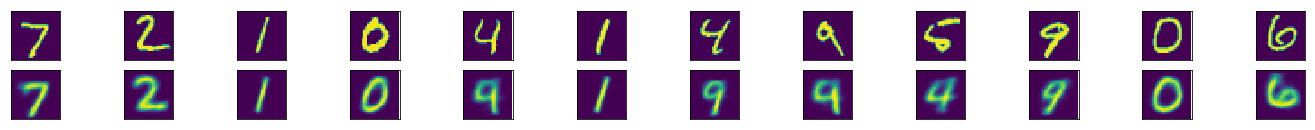

In [8]:
fig, ax = plt.subplots(2,12, figsize=(24,2))
for i in range(12):
    a1, a2 = ax[:, i]
    a1.set_xticks([])
    a2.set_xticks([])
    a1.imshow(x.asnumpy()[i,0,:,:])
    #a1.plot([0,28], [14,14], 'r')
    a2.imshow(reconst.asnumpy()[i,:,:])
    #a2.plot([0,28], [14,14], 'r')
    a1.set_xticks([])
    a2.set_xticks([])
    a1.set_xlim([0,28])
    a2.set_xlim([0,28])
    a1.set_yticks([])
    a2.set_yticks([])